In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as T

%matplotlib inline

In [2]:
drugs = ['FPV', 'ATV', 'IDV', 'LPV', 'NFV', 'SQV', 'TPV', 'DRV',]
drug = drugs[0]
protein = 'protease'

data, feat_cols = cf.get_cleaned_data(protein, drug)

# Just checking:
cf.test_data_integrity(data)

## Now, let's do data transformations.
data_mw = cf.to_numeric_rep(data, feat_cols, rep='mw')
data_pKa = cf.to_numeric_rep(data, feat_cols, rep='pKa')

# Split the MW data into a training set, and test set.
X_mw, Y_mw, X_train_mw, X_test_mw, Y_train_mw, Y_test_mw = cf.to_train_test_split(data_mw, feat_cols, drug, test_size=0.3)

# Convert all of the datapoints to numpy arrays.
X_mw = cf.pd2np(X_mw)
Y_mw = cf.pd2np(Y_mw)
X_train_mw = cf.pd2np(X_train_mw)
X_test_mw = cf.pd2np(X_test_mw)
Y_train_mw = cf.pd2np(Y_train_mw)
Y_test_mw = cf.pd2np(Y_test_mw)


# Do likewise for pKa data
X_pKa, Y_pKa, X_train_pKa, X_test_pKa, Y_train_pKa, Y_test_pKa = cf.to_train_test_split(data_pKa, feat_cols, drug, test_size=0.3)

# Convert all of the datapoints to numpy arrays.
X_pKa = cf.pd2np(X_pKa)
Y_pKa = cf.pd2np(Y_pKa)
X_train_pKa = cf.pd2np(X_train_pKa)
X_test_pKa = cf.pd2np(X_test_pKa)
Y_train_pKa = cf.pd2np(Y_train_pKa)
Y_test_pKa = cf.pd2np(Y_test_pKa)

/Users/ericmjl/anaconda/envs/gsdash/lib/python3.5/site-packages/sklearn/preprocessing/data.py:184: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [3]:
# Train a random forest regressor on the mw and pKa data, and then
# use RF as a feature selector based on feature importances.


rfr_mw = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rfr_mw.fit(X_train_mw, Y_train_mw)


rfr_pKa = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rfr_pKa.fit(X_train_pKa, Y_train_pKa)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

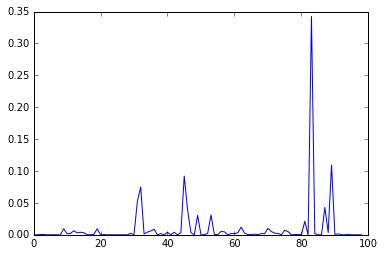

In [4]:
plt.plot(range(len(rfr_mw.feature_importances_)),
         rfr_mw.feature_importances_)

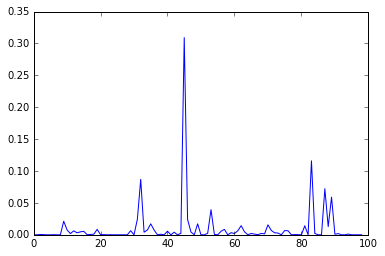

In [5]:
plt.plot(range(len(rfr_pKa.feature_importances_)),
         rfr_pKa.feature_importances_)

In [6]:
def find_num_feats(model):
    feat_importances = 0
    n_feats = 0
    while feat_importances < 0.9:
        n_feats += 1
        best_feats = np.argsort(model.feature_importances_)[-n_feats:]
        feat_importances = np.sum(model.feature_importances_[best_feats])
    return n_feats

In [7]:
%%time

# These are the minimum set of positions that comprise 90% of the total relative importance
n_feats_mw = find_num_feats(rfr_mw)
print(n_feats_mw)
mw_best_feats = np.argsort(rfr_mw.feature_importances_)[-n_feats_mw:]
np.sum(rfr_mw.feature_importances_[mw_best_feats])

18
CPU times: user 3.74 s, sys: 646 ms, total: 4.39 s
Wall time: 6.09 s


In [8]:
%%time
n_feats_pKa = find_num_feats(rfr_pKa)
print(n_feats_pKa)
pKa_best_feats = np.argsort(rfr_pKa.feature_importances_)[-n_feats_pKa:]
np.sum(rfr_pKa.feature_importances_[pKa_best_feats])

23
CPU times: user 3.96 s, sys: 703 ms, total: 4.66 s
Wall time: 5.34 s


In [9]:
# Together, the following is the best set of features for prediction.
best_feats = np.unique(np.concatenate([mw_best_feats, pKa_best_feats]))
best_feats

array([ 9, 12, 19, 29, 31, 32, 35, 36, 45, 46, 49, 53, 56, 57, 62, 70, 71,
       76, 81, 83, 87, 88, 89])

In [10]:
# Now we do a Bayesian GLM using only those features
X_mw_featselect = X_mw[:, best_feats]
X_pKa_featselect = X_pKa[:, best_feats]

# Do train/test split
mw_split = train_test_split(X_mw_featselect, Y_mw, test_size=0.2)
pKa_split = train_test_split(X_pKa_featselect, Y_pKa, test_size=0.2)

X_train_mw, X_test_mw, Y_train_mw, Y_test_mw = mw_split
Y_train_mw = cf.pd2np(Y_train_mw)
Y_test_mw = cf.pd2np(Y_test_mw)
X_train_pKa, X_test_pKa, Y_train_pKa, Y_test_pKa = pKa_split
Y_train_pKa = cf.pd2np(Y_train_pKa)
Y_test_pKa = cf.pd2np(Y_test_pKa)

In [11]:
X_train_mw.shape, X_train_pKa.shape

((580, 23), (580, 23))

In [12]:
inputs_mw = theano.shared(X_train_mw)
inputs_pKa = theano.shared(X_train_pKa)
outputs = theano.shared(Y_train_pKa)

with pm.Model() as linreg:
    linweights_mw = pm.Normal('linweights_mw', mu=0, sd=1, shape=(X_train_mw.shape[1], 1))
    linbiases_mw = pm.Normal('linbiases_mw', mu=0, sd=1)
    
    output_mw = pm.Normal('Y_mw', T.dot(inputs_mw, linweights_mw) + linbiases_mw, observed=outputs)
    
#     linweights_pKa = pm.Normal('linweights_pKa', mu=0, sd=1, shape=(X_train_pKa.shape[1], 1))
#     linbiases_pKa = pm.Normal('linbiases_pKa', mu=0, sd=1, shape=(1))
    
#     output_pKa = pm.Normal('Y_pKa', T.dot(inputs_pKa, linweights_pKa) + linbiases_pKa, observed=outputs)
    
#     avg_preds = pm.Normal('Y_avg', T.mean([output_mw, output_pKa], axis=0), observed=outputs)

In [13]:
%%time

with linreg:
    v_params = pm.variational.advi(n=500000)

Iteration 0 [0%]: ELBO = -13147664938.15


KeyboardInterrupt: 

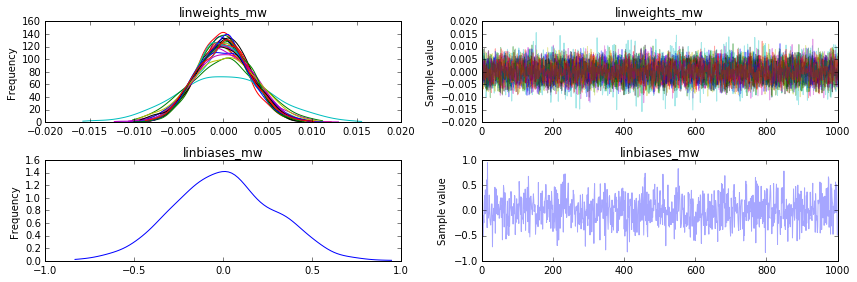

In [37]:
with linreg:
    trace = pm.variational.sample_vp(v_params, draws=1000)
    pm.traceplot(trace)